<img src="https://ustudy.world/wp-content/uploads/2014/10/George-Mason-University-logo.jpg " alt="GMU Logo" title="George Mason University" />
<hr style ="color:#99CC99">
    
<h2 style="font-family:Helvetica; color:#006633;">Final Project Working System</h2>
<h3 style="font-family:Helvetica; color:#006633;"> Sentiment Analysis on COVID-19 using Twitter Tweets</h3>

<p style="font-family:Helvetica; font-size:1.5em;"> 
Author: Shinoj Kumar<br>
Course Professor: Dr. Lindi Liao <br>
Course Name: Natural Language Processing <br>
Course Name and Section#: AIT 726-001<br>
University Name: George Mason University<br>
Date: December 7, 2020    <br>
</p>    
<hr style ="color:#99CC99" width="75%">
<p style="font-family:Helvetica; font-size:1.4em;"> 
Instructions: Our final project is a sentiment analysis of COVID-19 tweets with dates from January to July and September using model trained on a sentiment labeled COVID-19 tweets dataset. This working system details the data processing steps, which saves the process dataset as a pickle file, and the model implementions steps. The dataset and the pickled files are include in the submission. To ensure working system is not disrupted, please install all required packages detailed in the import section and allow for adequate time for the code to run. Given that the models include parameter tuning, upwards of 5-10 hours may be expected for all results to populate. Please see html of results for easier checking.<br>



     

In [ ]:
#left click on FinalProject_dataset folder and  'Add to my Drive'

#Make sure you mount your drive to colab. An authentication link will pop-up so click on it and enter the password.
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#Set working directory
%cd '/content/drive/My Drive/FinalProject_dataset2'
%ls


/content/drive/My Drive/FinalProject_dataset2
 baseline_datatset.pickle     main_combined_tweetIDs.csv
 dataset_with_sentiment.csv   model.png
 full_hydrated_dataset.csv    NN_dataset.pickle
 glove.6B.100d.txt           'Sentiment of the Tweets in March 2020.png'


## Import Packages

In [ ]:
#Install libraries 
#! pip install textblob
#! pip install pandas
! pip install emoji

In [ ]:
#Import packages
import os
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import tweepy as tw
import matplotlib.pyplot as plt

import nltk
import re
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
import urllib.request
import gensim
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer
from collections import defaultdict, Counter
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
import emoji
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import LSTM
from keras.layers import GlobalAveragePooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Data Preprocessing

In [ ]:
#load for dataset for baseline and new data test
tweet_data_orig= pd.read_csv('main_combined_tweetIDs.csv')
tweet_data=shuffle(tweet_data_orig)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#load dataset with labels for classification with NN
tweet_data_withlabels=pd.read_csv('dataset_with_sentiment.csv')
tweet_data_withlabels=shuffle(tweet_data_withlabels)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,6,7,10,11,12,15,16,17,18,19,20,21,22,27,28,29,32,33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#total features and rows for baseline
tweet_data.shape

(1301887, 34)

In [ ]:
#total features and rows for classification with NN

In [ ]:
tweet_data.head(5)

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,lang,place,possibly_sensitive,retweet_count,retweet_id,retweet_screen_name,source,text,tweet_url,user_created_at,user_screen_name,user_default_profile_image,user_description,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified
735770,NaN,Sat May 30 16:53:34 +0000 2020,NaN,NaN,NaN,0,1266774767782309891,NaN,NaN,NaN,es,NaN,NaN,1,1.266765e+18,buffonSoy,"<a href=""http://twitter.com/download/android"" ...","RT @buffonSoy: Calor, humedad y tapabocas: la ...",https://twitter.com/BlascoGianelli/status/1266...,Thu Apr 05 01:24:43 +0000 2018,BlascoGianelli,False,NaN,4600,173,411,0,"Montevideo, Uruguay",Yo no saqué la foto,BlascoGianelli,4048,NaN,NaN,False
967707,NaN,Thu Apr 30 15:01:33 +0000 2020,NaN,NaN,https://twitter.com/frasesdem3rda/status/12558...,0,1255874942014496774,NaN,NaN,NaN,pt,NaN,False,0,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...","Tadinhoo, fiquei com pena https://t.co/2VtlG9Thdu",https://twitter.com/__lunasilva__/status/12558...,Fri Jan 01 12:09:45 +0000 2016,__lunasilva__,False,Colgaia📚 SMF📍// ig: __lunasilva__,15070,198,518,0,NaN,Luna✨,__lunasilva__,48535,NaN,https://curiouscat.me/Luna_Silva,False
575044,NaN,Tue Jun 30 23:32:08 +0000 2020,TrumpKnewAndDidNothing,NaN,NaN,0,1278109094847475713,NaN,NaN,NaN,en,NaN,NaN,130,1.278064e+18,tooldtobehere,"<a href=""http://twitter.com/download/android"" ...",RT @tooldtobehere: #TrumpKnewAndDidNothing\nDJ...,https://twitter.com/DebbieGlpaints/status/1278...,Sat Dec 26 23:57:36 +0000 2015,DebbieGlpaints,True,NaN,4750,14,78,0,NaN,Debbie Glass,DebbieGlpaints,11476,NaN,NaN,False
1194467,NaN,Sun Mar 15 22:24:13 +0000 2020,NaN,NaN,https://twitter.com/cudegracah/status/12393073...,0,1239316500357484545,NaN,NaN,NaN,pt,NaN,False,0,NaN,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",imagina o tanto de preconceito que vai pro cai...,https://twitter.com/carloshmelo0/status/123931...,Sun Sep 24 23:59:40 +0000 2017,carloshmelo0,False,eh isso,7027,104,448,0,NaN,carlxs,carloshmelo0,7568,NaN,NaN,False
1137029,NaN,Sat Feb 29 20:19:20 +0000 2020,NaN,NaN,https://www.oann.com/first-u-s-death-from-coro...,0,1233849251614117889,NaN,NaN,NaN,en,NaN,False,3,1.233849e+18,donaldherring11,"<a href=""http://twitter.com/download/android"" ...",RT @donaldherring11: First u.s. Death from vir...,https://twitter.com/donaldherring11/status/123...,Thu Jun 11 06:33:42 +0000 2015,donaldherring11,False,REPUBLICAN\nCHIRSTIAN. I stand with Israel. ...,82793,12518,13748,7,United States -,Donald Herring,donaldherring11,113224,NaN,NaN,False


In [ ]:
#Subset necessary features of interest
tweet_data_sub= tweet_data[['created_at','user_name', 'user_screen_name','text', 'user_friends_count', 'user_followers_count','user_verified','lang']]

In [ ]:
#subset to only include english tweets
tweet_data_sub= tweet_data_sub[(tweet_data_sub['lang']=='en')]

In [ ]:
##total features and rows for english only
tweet_data_sub.shape

(948491, 8)

In [ ]:
#check if there are any duplicates in the tweets
tweet_data ['text'].duplicated().any()

True

In [ ]:
#drop duplicates from tweets 
tweet_data_pre=tweet_data_sub.drop_duplicates(['text'], keep='last')

#drop lang column
tweet_data_pre=tweet_data_pre[tweet_data_pre.columns.difference(['lang'])]

tweet_data_pre.shape

(384820, 7)

In [ ]:
tweet_data_pre.head(5)

,created_at,text,user_followers_count,user_friends_count,user_name,user_screen_name,user_verified
1142305,Sat Feb 29 20:17:15 +0000 2020,RT @hasanthehun: if i get coronavirus from sit...,1346,1084,Micah Sharon,MicahSharon2013,False
977942,Thu Apr 30 15:05:34 +0000 2020,i want nothing more than the complete studio g...,101,534,Ryan Ellis,DisturbInfinity,False
917737,Fri Jan 31 00:41:53 +0000 2020,Personally i would be fine with being quaranti...,861,1117,Jensen Freeman,_Dirty_J,False
273861,Tue Sep 01 01:37:26 +0000 2020,Square up covid 👊 https://t.co/IUobeU7gnM,612,319,Chris Sánchez,itsqris,False
1033978,Sat Feb 29 20:37:04 +0000 2020,RT @_s_k_1_4: They will definitely patent it a...,54,60,Acayd,Acayd2,False


In [ ]:
from datetime import datetime
from dateutil.parser import parse

#reformat date
tweet_data_pre['date'] = tweet_data_pre['created_at'].apply(parse)

#drop lang and Id column
tweet_data_pre=tweet_data_pre[tweet_data_pre.columns.difference(['created_at'])]


In [ ]:
tweet_data_pre['month-day'] = tweet_data_pre['date'].dt.strftime('%b-%d')
tweet_data_pre['month'] = tweet_data_pre['date'].dt.strftime('%b')
tweet_data_pre.head(5)

,date,text,user_followers_count,user_friends_count,user_name,user_screen_name,user_verified,month-day,month
1142305,2020-02-29 20:17:15+00:00,RT @hasanthehun: if i get coronavirus from sit...,1346,1084,Micah Sharon,MicahSharon2013,False,Feb-29,Feb
977942,2020-04-30 15:05:34+00:00,i want nothing more than the complete studio g...,101,534,Ryan Ellis,DisturbInfinity,False,Apr-30,Apr
917737,2020-01-31 00:41:53+00:00,Personally i would be fine with being quaranti...,861,1117,Jensen Freeman,_Dirty_J,False,Jan-31,Jan
273861,2020-09-01 01:37:26+00:00,Square up covid 👊 https://t.co/IUobeU7gnM,612,319,Chris Sánchez,itsqris,False,Sep-01,Sep
1033978,2020-02-29 20:37:04+00:00,RT @_s_k_1_4: They will definitely patent it a...,54,60,Acayd,Acayd2,False,Feb-29,Feb


In [ ]:
#Rebalancing dataset to make sure equal amounts of tweets for each month
tweet_data_pre['month'].value_counts()

Jun    86926
Sep    83867
Mar    83009
Feb    42953
Apr    38045
May    29960
Jan    20060
Name: month, dtype: int64

In [ ]:
#group by lowest number of tweets in month
tweet_data_balanced=tweet_data_pre.groupby('month').head(20059)

In [ ]:
#check that it's balanced
tweet_data_balanced['month'].value_counts()

May    20059
Mar    20059
Jan    20059
Apr    20059
Sep    20059
Jun    20059
Feb    20059
Name: month, dtype: int64

In [ ]:
#Cleaning 
import re

#function to find pattern to remove username mentions
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt


In [ ]:
#Cleaning 
tweet_data_balanced['tweet_cleaned'] = np.vectorize(remove_pattern)(tweet_data_balanced['text'], "@[\w]*")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#Capture hashtags
tweet_data_balanced['hashtag'] = tweet_data_balanced['tweet_cleaned'].apply(lambda x: re.findall(r"#(\w+)", x))
#remove emoticon
tweet_data_balanced['tweet_cleaned']=tweet_data_balanced['tweet_cleaned'].str.replace("([?:[<>]?[:;=8][\-o\*\']?[\)\]|\(\[dDpPo\/\:\}\{@\|\\]|[\)\]\(\[dDpP\/\:\}\{@\|\\][\-o\*\']?[:;=8][<>]?|[<3]])+", "")
#remove digits
tweet_data_balanced['tweet_cleaned']=tweet_data_balanced['tweet_cleaned'].str.replace("([0-7]+|[9]+)", "")
#remove tags
tweet_data_balanced['tweet_cleaned']=tweet_data_balanced['tweet_cleaned'].str.replace("(?:<[^>]+>)","")
#remove RT
tweet_data_balanced['tweet_cleaned'] = tweet_data_balanced['tweet_cleaned'] .apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# remove special characters, numbers, punctuations
tweet_data_balanced['tweet_cleaned'] = tweet_data_balanced['tweet_cleaned'].str.replace('\W+', ' ')
#lower case 
tweet_data_balanced['tweet_cleaned'] = tweet_data_balanced['tweet_cleaned'].str.lower()


In [ ]:
#remove emojis
tweet_data_balanced['tweet_cleaned_noemoji']=tweet_data_balanced['tweet_cleaned'].str.replace(emoji.get_emoji_regexp(),"")

In [ ]:
tweet_data_balanced.head(5)

,date,text,user_followers_count,user_friends_count,user_name,user_screen_name,user_verified,month-day,month,tweet_cleaned,hashtag,tweet_cleaned_noemoji
1142305,2020-02-29 20:17:15+00:00,RT @hasanthehun: if i get coronavirus from sit...,1346,1084,Micah Sharon,MicahSharon2013,False,Feb-29,Feb,coronavirus from sitting here long instead get...,[],coronavirus from sitting here long instead get...
977942,2020-04-30 15:05:34+00:00,i want nothing more than the complete studio g...,101,534,Ryan Ellis,DisturbInfinity,False,Apr-30,Apr,want nothing more than complete studio ghibli ...,[],want nothing more than complete studio ghibli ...
917737,2020-01-31 00:41:53+00:00,Personally i would be fine with being quaranti...,861,1117,Jensen Freeman,_Dirty_J,False,Jan-31,Jan,personally would fine with being quarantined h...,[],personally would fine with being quarantined h...
273861,2020-09-01 01:37:26+00:00,Square up covid 👊 https://t.co/IUobeU7gnM,612,319,Chris Sánchez,itsqris,False,Sep-01,Sep,square covid https t co iuobeugnm,[],square covid https t co iuobeugnm
1033978,2020-02-29 20:37:04+00:00,RT @_s_k_1_4: They will definitely patent it a...,54,60,Acayd,Acayd2,False,Feb-29,Feb,they will definitely patent make expensive maj...,[],they will definitely patent make expensive maj...


In [ ]:
#Saving rebalanced dataset
import pickle
#tweet_data_balanced.to_pickle('baseline_datatset.pickle')

tweet_data_balanced = pd.read_pickle('/content/drive/My Drive/FinalProject_dataset2/baseline_datatset.pickle')


In [ ]:
tweet_data_balanced.head(5)

,date,text,user_followers_count,user_friends_count,user_name,user_screen_name,user_verified,month-day,month,tweet_cleaned,hashtag,tweet_cleaned_noemoji
46751,2020-09-30 23:03:31+00:00,Imagine covering this #NBAFinals pre-COVID and...,704,836,Hombre De Acero 💥🔗,terence_ray,False,Sep-30,Sep,imagine covering this nbafinals pre covid gett...,[NBAFinals],imagine covering this nbafinals pre covid gett...
288625,2020-09-01 01:42:59+00:00,"@JohnCornyn FUN FACT\nCanada Population : 37,5...",5806,6397,Alien Nation Refugee 🇨🇦🌊🧢 💙🌈 #JoeBiden2020,raichle6ix,False,Sep-01,Sep,fact canada population atlanta population cana...,[RepublicanVirus],fact canada population atlanta population cana...
83262,2020-09-30 23:19:53+00:00,@Justin_Ling Those of us who have actually rea...,3,159,Tom Daweson,TomDawesonTO,False,Sep-30,Sep,those have actually read krever commission rep...,[],those have actually read krever commission rep...
204760,2020-09-01 01:11:41+00:00,I’m still in shock that adam driver joined the...,334,1239,Hånš,ssie_bannion,False,Sep-01,Sep,still shock that adam driver joined military a...,[],still shock that adam driver joined military a...
254073,2020-09-01 01:30:05+00:00,Shephard &amp; van Alebeek - Life behind the M...,576,0,Radio On,radio_on_berlin,False,Sep-01,Sep,shephard amp alebeek life behind mask the heal...,"[coronavirus, healthmask, Berlinstories]",shephard amp alebeek life behind mask the heal...


In [ ]:
#Baseline solution
#VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()
tweets_sentiment_vader=tweet_data_balanced['tweet_cleaned'].apply(lambda x: sia.polarity_scores(x))

In [ ]:
tweets_post= pd.concat([tweet_data_balanced,tweets_sentiment_vader.apply(pd.Series)],1)


In [ ]:
tweets_post.head(10)

,date,text,user_followers_count,user_friends_count,user_name,user_screen_name,user_verified,month-day,month,tweet_cleaned,hashtag,tweet_cleaned_noemoji,neg,neu,pos,compound
46751,2020-09-30 23:03:31+00:00,Imagine covering this #NBAFinals pre-COVID and...,704,836,Hombre De Acero 💥🔗,terence_ray,False,Sep-30,Sep,imagine covering this nbafinals pre covid gett...,[NBAFinals],imagine covering this nbafinals pre covid gett...,0.000,0.857,0.143,0.2500
288625,2020-09-01 01:42:59+00:00,"@JohnCornyn FUN FACT\nCanada Population : 37,5...",5806,6397,Alien Nation Refugee 🇨🇦🌊🧢 💙🌈 #JoeBiden2020,raichle6ix,False,Sep-01,Sep,fact canada population atlanta population cana...,[RepublicanVirus],fact canada population atlanta population cana...,0.000,1.000,0.000,0.0000
83262,2020-09-30 23:19:53+00:00,@Justin_Ling Those of us who have actually rea...,3,159,Tom Daweson,TomDawesonTO,False,Sep-30,Sep,those have actually read krever commission rep...,[],those have actually read krever commission rep...,0.180,0.820,0.000,-0.6697
204760,2020-09-01 01:11:41+00:00,I’m still in shock that adam driver joined the...,334,1239,Hånš,ssie_bannion,False,Sep-01,Sep,still shock that adam driver joined military a...,[],still shock that adam driver joined military a...,0.415,0.585,0.000,-0.8176
254073,2020-09-01 01:30:05+00:00,Shephard &amp; van Alebeek - Life behind the M...,576,0,Radio On,radio_on_berlin,False,Sep-01,Sep,shephard amp alebeek life behind mask the heal...,"[coronavirus, healthmask, Berlinstories]",shephard amp alebeek life behind mask the heal...,0.000,1.000,0.000,0.0000
731767,2020-05-30 16:51:56+00:00,@AdvisoryNess @ShawnChurchill @TrumpLasVegas @...,404,1899,Ayfkm,ayfkmnow,False,May-30,May,irony coming middle ultimate failure handling ...,[],irony coming middle ultimate failure handling ...,0.162,0.722,0.116,-0.0772
658972,2020-03-11 20:04:48+00:00,get tae out of there thank you https://t.co/ZA...,283,234,sսsa⁷𐤀,taehyungweeb,False,Mar-11,Mar,there thank https t co zaqkhcnpa,[],there thank https t co zaqkhcnpa,0.000,0.615,0.385,0.3612
94887,2020-09-30 23:25:03+00:00,"RT @Jpompia: First pandemic, now smoke...from ...",620,116,Tracy Harmon,tracywumps,False,Sep-30,Sep,first pandemic smoke from million acres have b...,[],first pandemic smoke from million acres have b...,0.000,1.000,0.000,0.0000
358078,2020-04-15 14:25:51+00:00,"@qtum I think Qtum is great, maybe start some ...",524,804,Lilging777,jorgvanhaaren,False,Apr-15,Apr,think qtum great maybe start some live video s...,[],think qtum great maybe start some live video s...,0.000,0.843,0.157,0.6249
223297,2020-09-01 01:18:37+00:00,I'm so excited for fall. It's one of my fav se...,698,668,ScareJo🎃👻👽,jojosephs2020,False,Sep-01,Sep,excited fall it s seasons even corona can t stop,[],excited fall it s seasons even corona can t stop,0.208,0.566,0.226,0.0516


In [ ]:
#Create new feature with sentiment score
sentiment=[]
for i in tweets_post['compound']:
    if i>0.05:
        sentiment.append('positive')
    elif i > -0.05 and i < 0.05:
        sentiment.append('neutral')
    else:
        sentiment.append('negative')
tweets_post['sentiment']=sentiment


In [ ]:
tweets_post.head()

,date,text,user_followers_count,user_friends_count,user_name,user_screen_name,user_verified,month-day,month,tweet_cleaned,hashtag,tweet_cleaned_noemoji,neg,neu,pos,compound,sentiment
46751,2020-09-30 23:03:31+00:00,Imagine covering this #NBAFinals pre-COVID and...,704,836,Hombre De Acero 💥🔗,terence_ray,False,Sep-30,Sep,imagine covering this nbafinals pre covid gett...,[NBAFinals],imagine covering this nbafinals pre covid gett...,0.000,0.857,0.143,0.2500,positive
288625,2020-09-01 01:42:59+00:00,"@JohnCornyn FUN FACT\nCanada Population : 37,5...",5806,6397,Alien Nation Refugee 🇨🇦🌊🧢 💙🌈 #JoeBiden2020,raichle6ix,False,Sep-01,Sep,fact canada population atlanta population cana...,[RepublicanVirus],fact canada population atlanta population cana...,0.000,1.000,0.000,0.0000,neutral
83262,2020-09-30 23:19:53+00:00,@Justin_Ling Those of us who have actually rea...,3,159,Tom Daweson,TomDawesonTO,False,Sep-30,Sep,those have actually read krever commission rep...,[],those have actually read krever commission rep...,0.180,0.820,0.000,-0.6697,negative
204760,2020-09-01 01:11:41+00:00,I’m still in shock that adam driver joined the...,334,1239,Hånš,ssie_bannion,False,Sep-01,Sep,still shock that adam driver joined military a...,[],still shock that adam driver joined military a...,0.415,0.585,0.000,-0.8176,negative
254073,2020-09-01 01:30:05+00:00,Shephard &amp; van Alebeek - Life behind the M...,576,0,Radio On,radio_on_berlin,False,Sep-01,Sep,shephard amp alebeek life behind mask the heal...,"[coronavirus, healthmask, Berlinstories]",shephard amp alebeek life behind mask the heal...,0.000,1.000,0.000,0.0000,neutral


In [ ]:
print("Total number of tweets:  %s" % str(len(tweets_post.index)))

tweets_post_positive = tweets_post[tweets_post['sentiment'] == 'positive']
print("Number of Positive tweets: %s" % str(len(tweets_post_positive.index)))

tweets_post_negative = tweets_post[tweets_post['sentiment'] == 'negative']
print("Number of Negative tweets: %s" % str(len(tweets_post_negative.index)))

tweets_post_neutral = tweets_post[tweets_post['sentiment'] == 'neutral']
print("Number of Neutral tweets: %s" % str(len(tweets_post_neutral.index)))

Total number of tweets:  140413
Number of Positive tweets: 49781
Number of Negative tweets: 50682
Number of Neutral tweets: 39950


(array([    0.,  2500.,  5000.,  7500., 10000., 12500., 15000., 17500.,
        20000., 22500.]), <a list of 10 Text major ticklabel objects>)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


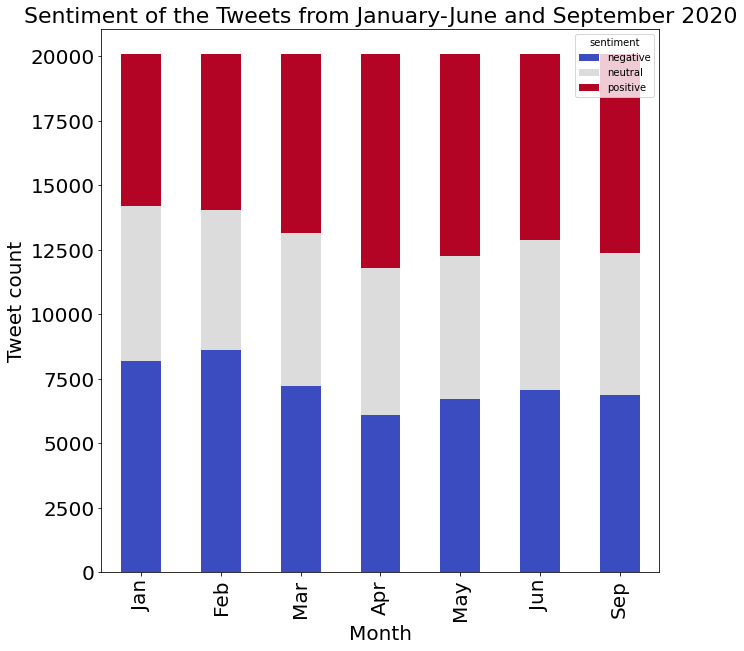

In [ ]:
order = ['Jan', 'Feb', 'Mar','Apr','May','Jun','Sep']
plot_tweet_date = tweets_post.groupby(['month', 'sentiment']).size().reset_index().pivot(columns='sentiment', index='month', values=0).loc[order].plot(kind='bar',colormap='coolwarm', stacked=True,figsize=(10,10))
#plot_tweet_date = tweets_post.groupby(['month', 'sentiment']).size().reset_index().pivot(columns='sentiment', index='month', values=0).plot(kind='bar',colormap='coolwarm', stacked=True,figsize=(10,10))
plot_tweet_date.set_xlabel("Month", fontsize= 20)
plot_tweet_date.set_ylabel("Tweet count", fontsize= 20)

plot_tweet_date.set_title("Sentiment of the Tweets from January-June and September 2020", fontname='Arial', fontsize=22)

# Set the font name for axis tick labels to be Comic Sans
for tick in plot_tweet_date.get_xticklabels():
    tick.set_fontname("Arial")
for tick in plot_tweet_date.get_yticklabels():
    tick.set_fontname("Arial")
    
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)  



#plt.savefig("Sentiment of the Tweets from January-June and September 2020.png", format='png', dpi=500)

In [ ]:
#get tweets for just march 
tweets_post_mar= tweets_post[(tweets_post['month']=='Mar')]

In [ ]:
#check counts to rebalance 
tweets_post_mar['month-day'].value_counts()

Mar-31    6977
Mar-01    6663
Mar-11    3506
Mar-15    2913
Name: month-day, dtype: int64

In [ ]:
#balance based on lowest number
tweets_post_mar_balanced=tweets_post_mar.groupby('month-day').head(2913)

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.]),
 <a list of 8 Text major ticklabel objects>)

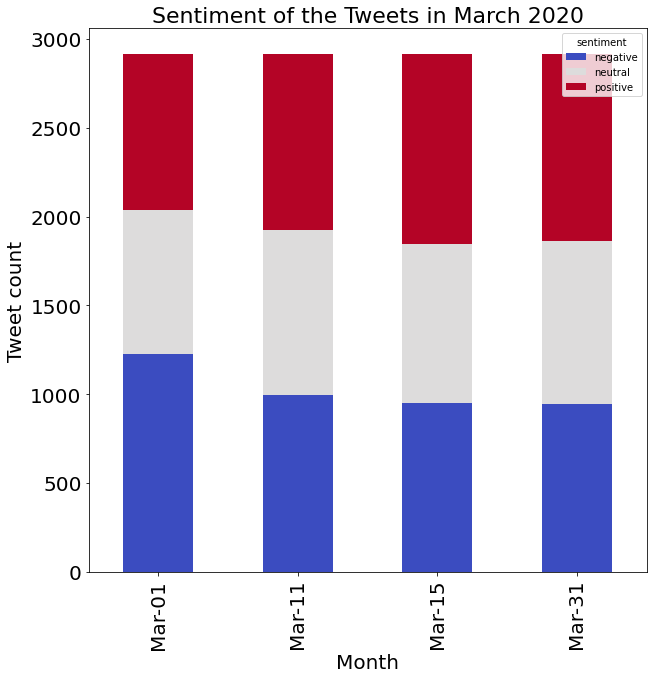

In [ ]:
#order = ['Jan', 'Feb', 'Mar','Apr','May','Jun','Sep']
plot_tweet_march = tweets_post_mar_balanced.groupby(['month-day', 'sentiment']).size().reset_index().pivot(columns='sentiment', index='month-day', values=0).plot(kind='bar',colormap='coolwarm', stacked=True,figsize=(10,10))
plot_tweet_march.set_xlabel("Month", fontsize= 20)
plot_tweet_march.set_ylabel("Tweet count", fontsize= 20)

plot_tweet_march.set_title("Sentiment of the Tweets in March 2020", fontname='Arial', fontsize=22)

# Set the font name for axis tick labels to be Comic Sans
for tick in plot_tweet_march.get_xticklabels():
    tick.set_fontname("Arial")
for tick in plot_tweet_march.get_yticklabels():
    tick.set_fontname("Arial")
    
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)  



#plt.savefig('Sentiment of the Tweets in March 2020.png', format='png', dpi=500)

Text(0, 0.5, 'Number of Tweets')

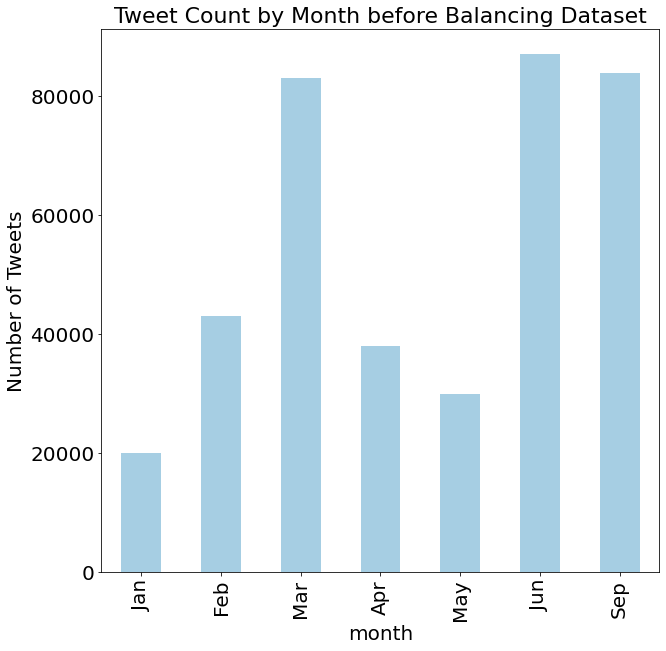

In [ ]:
#distribution of tweets
order = ['Jan', 'Feb', 'Mar','Apr','May','Jun','Sep']
month_plot=tweet_data_pre['month'].value_counts().sort_index().loc[order].plot(kind='bar', figsize=(10,10), cmap= 'Paired')

month_plot.set_xlabel("")

month_plot.set_title("Tweet Count by Month before Balancing Dataset", fontname='Arial', fontsize=22)

# Set the font name for axis tick labels to be Comic Sans
for tick in month_plot.get_xticklabels():
    tick.set_fontname("Arial")
for tick in month_plot.get_yticklabels():
    tick.set_fontname("Arial")
    
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)  
plt.xlabel("month", fontsize=20)
plt.ylabel("Number of Tweets", fontsize=20)

Text(0, 0.5, 'Number of Tweets')

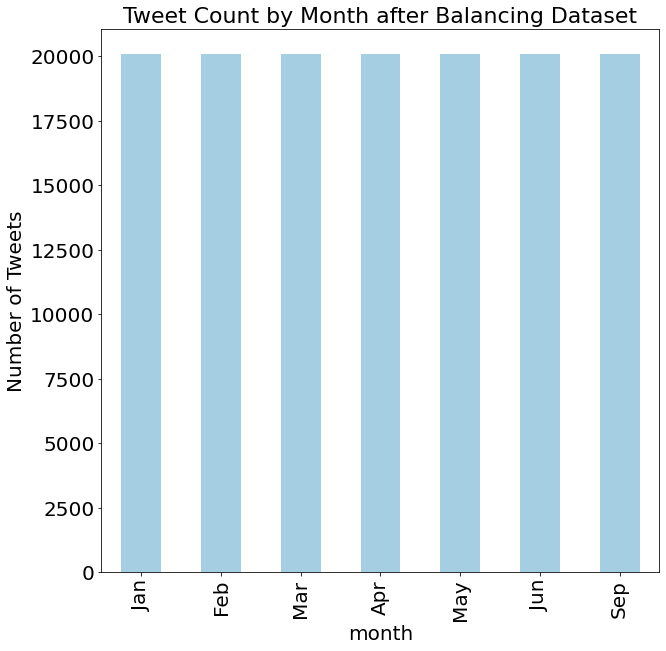

In [ ]:
#distribution of tweets
order = ['Jan', 'Feb', 'Mar','Apr','May','Jun','Sep']
month_plot=tweet_data_balanced['month'].value_counts().sort_index().loc[order].plot(kind='bar', figsize=(10,10), cmap= 'Paired')

month_plot.set_xlabel("")

month_plot.set_title("Tweet Count by Month after Balancing Dataset", fontname='Arial', fontsize=22)

# Set the font name for axis tick labels to be Comic Sans
for tick in month_plot.get_xticklabels():
    tick.set_fontname("Arial")
for tick in month_plot.get_yticklabels():
    tick.set_fontname("Arial")
    
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)  
plt.xlabel("month", fontsize=20)
plt.ylabel("Number of Tweets", fontsize=20)

## Data with labels 


In [ ]:
#Tweets with labels

In [ ]:
tweet_data_withlabels.shape

(1136692, 35)

In [ ]:
#Subset necessary features of interest
tweets_with_labels= tweet_data_withlabels[['user_screen_name','text', 'user_friends_count', 'user_followers_count','user_verified','lang', 'sentiment_score']]

In [ ]:
#subset to only include english tweets
tweets_with_labels= tweets_with_labels[(tweets_with_labels['lang']=='en')]

In [ ]:
##total features and rows for english only
tweets_with_labels.shape

(852493, 7)

In [ ]:
#check if there are any duplicates in the tweets
tweets_with_labels['text'].duplicated().any()
#drop duplicates from tweets
tweets_with_labels=tweets_with_labels.drop_duplicates(['text'], keep='last')
#drop lang column
tweets_with_labels=tweets_with_labels[tweets_with_labels.columns.difference(['lang'])]


In [ ]:
#Cleaning 
tweets_with_labels['tweet_cleaned'] = np.vectorize(remove_pattern)(tweets_with_labels['text'], "@[\w]*")

In [ ]:
#Capture hashtags
tweets_with_labels['hashtag'] = tweets_with_labels['tweet_cleaned'].apply(lambda x: re.findall(r"#(\w+)", x))
#remove emoticon
tweets_with_labels['tweet_cleaned']=tweets_with_labels['tweet_cleaned'].str.replace("([?:[<>]?[:;=8][\-o\*\']?[\)\]|\(\[dDpPo\/\:\}\{@\|\\]|[\)\]\(\[dDpP\/\:\}\{@\|\\][\-o\*\']?[:;=8][<>]?|[<3]])+", "")
#remove digits
tweets_with_labels['tweet_cleaned']=tweets_with_labels['tweet_cleaned'].str.replace("([0-7]+|[9]+)", "")
#remove tags
tweets_with_labels['tweet_cleaned']=tweets_with_labels['tweet_cleaned'].str.replace("(?:<[^>]+>)","")
#remove RT
tweets_with_labels['tweet_cleaned'] = tweets_with_labels['tweet_cleaned'] .apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# remove special characters, numbers, punctuations
tweets_with_labels['tweet_cleaned'] = tweets_with_labels['tweet_cleaned'].str.replace('\W+', ' ')
#lower case 
tweets_with_labels['tweet_cleaned'] = tweets_with_labels['tweet_cleaned'].str.lower()


In [ ]:
#remove emojis
tweets_with_labels['tweet_cleaned_noemoji']=tweets_with_labels['tweet_cleaned'].str.replace(emoji.get_emoji_regexp(),"")

In [ ]:
#Fix labels of sentiment score
sentiment_labels=[]
for i in tweets_with_labels['sentiment_score']:
    if i>0.05:
        sentiment_labels.append('positive')
    elif i > -0.05 and i < 0.05:
        sentiment_labels.append('neutral')
    else:
        sentiment_labels.append('negative')
tweets_with_labels['sentiment']=sentiment_labels

In [ ]:
tweets_with_labels.head(5)

,sentiment_score,text,user_followers_count,user_friends_count,user_screen_name,user_verified,tweet_cleaned,hashtag,tweet_cleaned_noemoji,sentiment
975312,-0.066667,me with my whole body aching: “omg corona viru...,23223.0,5772.0,kissyjonas,False,with whole body aching omg corona virus no it ...,[],with whole body aching omg corona virus no it ...,negative
732908,1.000000,This is. the best way. to save from Corona ht...,219.0,187.0,khanbetanigmai1,False,this best way save from corona https t co pnmq...,[],this best way save from corona https t co pnmq...,positive
961592,-0.166667,Such people are irresponsible .. and they can'...,12.0,161.0,Rahul27021991,False,such people irresponsible they can t accept th...,[],such people irresponsible they can t accept th...,negative
361248,0.125000,State of #Berlin (not to be confused with Germ...,4634.0,675.0,startuprad_io,False,state berlin not confused with germany receive...,"[Berlin, TechNews, startups, startupnews, busi...",state berlin not confused with germany receive...,positive
502437,-0.600000,"@_thaprettyone Yea since corona, ughhhh this d...",1381.0,650.0,A_RealHippie,False,since corona ughhhh this depressing,[],since corona ughhhh this depressing,negative


In [ ]:
#Rebalance dataset by sentiment 
#check counts to rebalance 
tweets_with_labels['sentiment'].value_counts()


neutral     132167
positive    102778
negative     61599
Name: sentiment, dtype: int64

In [ ]:
#rebalance dataset by lowest
tweets_with_labels_balanced=tweets_with_labels.groupby('sentiment').head(61599)

In [ ]:
#check that it's balanced
tweets_with_labels_balanced['sentiment'].value_counts()

negative    61599
neutral     61599
positive    61599
Name: sentiment, dtype: int64

# Modeling developnment

In [ ]:
#Import packages
import os
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import tweepy as tw
import matplotlib.pyplot as plt

import nltk
import re
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
import urllib.request
import gensim
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer
from collections import defaultdict, Counter
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
import emoji
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import LSTM
from keras.layers import GlobalAveragePooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pydot
import graphviz
import keras.backend as K
import IPython
import random as rn
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Implementing Models

In [ ]:
#generate random seed
def random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   rn.seed(seed)

In [ ]:
#set seed
random_seeds(1234)

In [ ]:
#read in balanced dataset: downsampled dataset
tweets_with_labels_down = pd.read_pickle('/content/drive/My Drive/FinalProject_dataset2/NN_dataset.pickle')

In [ ]:
#RNN Method 

In [ ]:
def label_encoding(sentiment):
    LE = LabelEncoder()
    fit=LE.fit(sentiment.astype(str))
    labels =fit.transform(sentiment)
    labels1 = to_categorical(labels)
    return labels1, labels, fit

In [ ]:
label=tweets_with_labels_down ['sentiment']
label.shape
#Implement label encoding function
y, y_NB, fit= label_encoding(label)

In [ ]:
#Taking the cleaned tweets as X for training the model.
X= tweets_with_labels_down ['tweet_cleaned'].values
X.shape

(184797,)

In [ ]:
#Splitting the data into train and test for Naive Bayes
X_train, X_test, y_train_NB, y_test_NB = train_test_split(X, y_NB, test_size=0.20, random_state=42)

In [ ]:
#Splitting the data into train and test for Neural Networks
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Baseline with Naive Bayes

In [ ]:
#import packages
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV

In [ ]:
# NB pipeline with frequency count, TFIDF 
NB_text = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])
parameters = {
    'vect__ngram_range': [(1,1),(1, 2), (2, 2)],
    'tfidf__norm': ('l1', 'l2'),
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)
}


In [ ]:
NB_classifier = GridSearchCV(NB_text, parameters, scoring='f1_macro')
NB_classifier.fit(X_train, y_train_NB)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        p

In [ ]:
print(NB_classifier.best_params_)

{'clf__alpha': 0.1, 'tfidf__norm': 'l1', 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}


In [ ]:
y_pred_NB=NB_classifier.predict(X_test)

In [ ]:
print(accuracy_score(y_test_NB, y_pred_NB))
CM_df_NB = pd.DataFrame(confusion_matrix(y_test_NB, y_pred_NB, labels=[0, 1, 2]),
                        index=['true:negative', 'true:neutral', 'true:positive'], 
                        columns=['pred:negative', 'pred:neutral', 'pred:positive'])
print(CM_df_NB)
print(classification_report(y_test_NB, y_pred_NB))

0.7631493506493506
               pred:negative  pred:neutral  pred:positive
true:negative          10178          1227            912
true:neutral            2268          8651           1474
true:positive           1540          1333           9377
              precision    recall  f1-score   support

           0       0.73      0.83      0.77     12317
           1       0.77      0.70      0.73     12393
           2       0.80      0.77      0.78     12250

    accuracy                           0.76     36960
   macro avg       0.77      0.76      0.76     36960
weighted avg       0.77      0.76      0.76     36960



## Predicting on the COVID Tweets with Naive Bayes Classifer (with downsampled dataset)

In [ ]:
#Use to predict on tweets with dates
tweet_data_balanced['sentiment_NB']=NB_classifier.predict(tweet_data_balanced['tweet_cleaned'])
tweet_data_balanced['sentiment_NB']=tweet_data_balanced['sentiment_NB'].replace([0,1,2],['negative','neutral','positive'])


In [ ]:
tweets_data_positive = tweet_data_balanced[tweet_data_balanced['sentiment_NB'] == 'positive']
print("Number of Positive tweets from NB classifer: %s" % str(len(tweets_data_positive.index)))

tweets_data_negative = tweet_data_balanced[tweet_data_balanced['sentiment_NB'] == 'negative']
print("Number of Negative tweets from NB classifer: %s" % str(len(tweets_data_negative.index)))

tweets_data_neutral = tweet_data_balanced[tweet_data_balanced['sentiment_NB'] == 'neutral']
print("Number of Neutral tweets from NB classifer: %s" % str(len(tweets_data_neutral.index)))

Number of Positive tweets from NB classifer: 61146
Number of Negative tweets from NB classifer: 41006
Number of Neutral tweets from NB classifer: 38261


(array([    0.,  2500.,  5000.,  7500., 10000., 12500., 15000., 17500.,
        20000., 22500.]), <a list of 10 Text major ticklabel objects>)

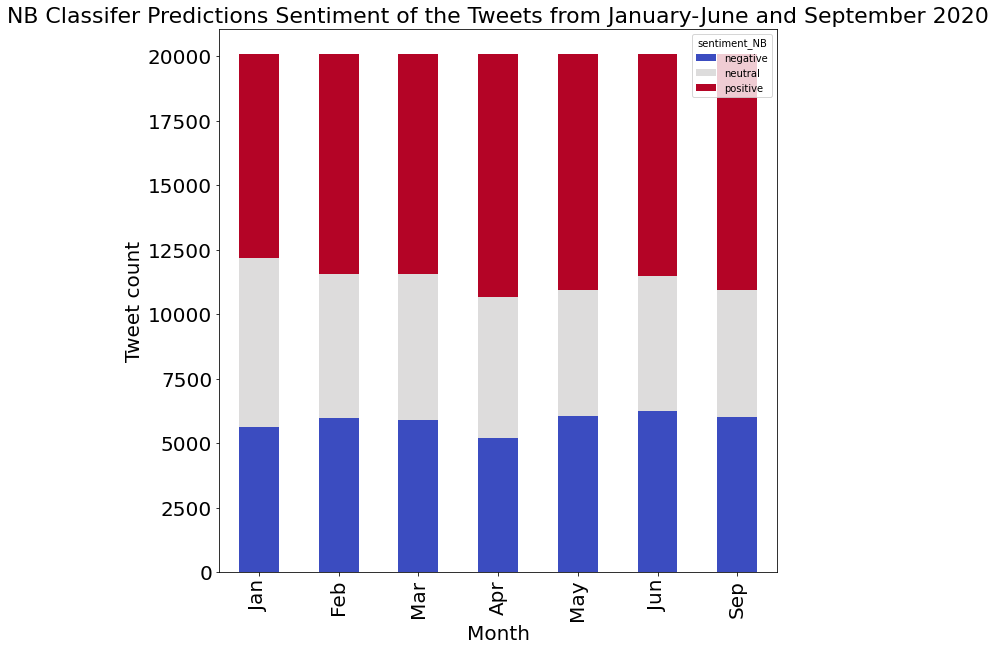

In [ ]:
order = ['Jan', 'Feb', 'Mar','Apr','May','Jun','Sep']
plot_tweet_date_NB = tweet_data_balanced.groupby(['month', 'sentiment_NB']).size().reset_index().pivot(columns='sentiment_NB', index='month', values=0).loc[order].plot(kind='bar',colormap='coolwarm', stacked=True,figsize=(10,10))
#plot_tweet_date = tweets_post.groupby(['month', 'sentiment']).size().reset_index().pivot(columns='sentiment', index='month', values=0).plot(kind='bar',colormap='coolwarm', stacked=True,figsize=(10,10))
plot_tweet_date_NB.set_xlabel("Month", fontsize= 20)
plot_tweet_date_NB.set_ylabel("Tweet count", fontsize= 20)

plot_tweet_date_NB.set_title("NB Classifer Predictions Sentiment of the Tweets from January-June and September 2020", fontname='Arial', fontsize=22)

# Set the font name for axis tick labels to be Comic Sans
for tick in plot_tweet_date_NB.get_xticklabels():
    tick.set_fontname("Arial")
for tick in plot_tweet_date_NB.get_yticklabels():
    tick.set_fontname("Arial")
    
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)  

# Neural Network Models

In [ ]:
#Preparing the embedding layer
#Using tokenizer to create word to text index
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
#Using Glove embedding to create feature matrix.
#GloVe is an unsupervised learning algorithm for obtaining vector representations for words. 
#GloVe model is to first create a huge word-context co-occurence matrix consisting of word, context
#pairs such that each element in this matrix represents how often a word occurs with the context
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/My Drive/FinalProject_dataset2/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
#The matrix will have 100 columns where each column will contain the GloVe word embeddings for the words in our corpus.
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

RNN model + softmax 
- Only tweets

In [ ]:
#RNN model+softmax
model_rnn = Sequential(name= "RNN_MODEL")
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model_rnn.add(embedding_layer)
model_rnn.add(LSTM(128, return_sequences=True, dropout=0.2))
model_rnn.add(LSTM(64, return_sequences=True, dropout=0.2))
model_rnn.add(LSTM(32))
model_rnn.add(Dense(3, activation='softmax'))
model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model_rnn.summary())

Model: "RNN_MODEL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          14756400  
_________________________________________________________________
lstm (LSTM)                  (None, 100, 128)          117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 64)           49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 14,935,571
Trainable params: 179,171
Non-trainable params: 14,756,400
_________________________________________________________________
None


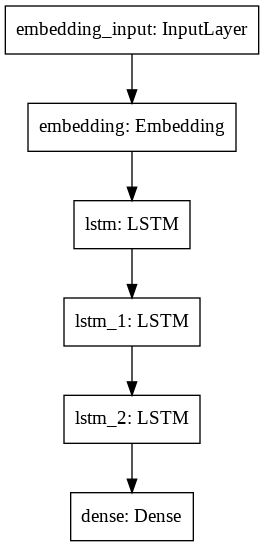

In [ ]:
#model diagram
tf.keras.utils.plot_model(model_rnn)

In [ ]:
#fit and evaluate on test data
history_rnn = model_rnn.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)
score_rnn = model_rnn.evaluate(X_test, y_test, verbose=1)

Epoch 1/10
924/924 [==============================] - 20s 22ms/step - loss: 1.0236 - acc: 0.4413 - val_loss: 0.8958 - val_acc: 0.6082
Epoch 2/10
924/924 [==============================] - 19s 21ms/step - loss: 0.9086 - acc: 0.5960 - val_loss: 0.9332 - val_acc: 0.5715
Epoch 3/10
924/924 [==============================] - 19s 21ms/step - loss: 0.8217 - acc: 0.6472 - val_loss: 0.7532 - val_acc: 0.6856
Epoch 4/10
924/924 [==============================] - 19s 21ms/step - loss: 0.7409 - acc: 0.6917 - val_loss: 0.6817 - val_acc: 0.7304
Epoch 5/10
924/924 [==============================] - 19s 21ms/step - loss: 0.6854 - acc: 0.7232 - val_loss: 0.6299 - val_acc: 0.7507
Epoch 6/10
924/924 [==============================] - 19s 21ms/step - loss: 0.6417 - acc: 0.7507 - val_loss: 1.6514 - val_acc: 0.3571
Epoch 7/10
924/924 [==============================] - 19s 21ms/step - loss: 0.8440 - acc: 0.6270 - val_loss: 0.6601 - val_acc: 0.7617
Epoch 8/10
924/924 [==============================] - 19s 21ms

In [ ]:
print("Test Score of RNN model:", score_rnn[0])
print("Test Accuracy of RNN model:", score_rnn[1])

Test Score of RNN model: 0.48377057909965515
Test Accuracy of RNN model: 0.8337662220001221


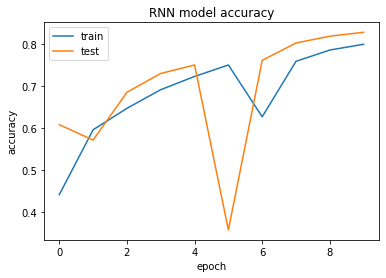

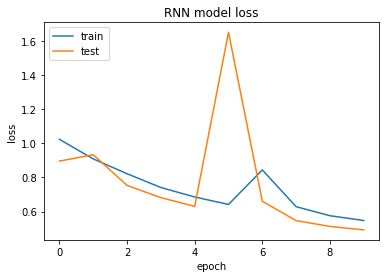

In [ ]:
plt.plot(history_rnn.history['acc'])
plt.plot(history_rnn.history['val_acc'])

plt.title('RNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])

plt.title('RNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
# Generate predictions for sentiment probabilities
def predict_test(model,testdata, labels, fit):
    predictions = model.predict(testdata)
    y_true=np.argmax(labels, axis=1)
    y_pred=np.argmax(predictions, axis = 1)
    print(y_pred)
    label_pred=fit.inverse_transform(y_pred)
    #metrics
    report = classification_report(y_true, y_pred, labels=[0, 1, 2])
    CM=confusion_matrix(y_true, y_pred)
    CM_df = pd.DataFrame(confusion_matrix(y_true, y_pred, labels=[0, 1, 2]),
                        index=['true:negative', 'true:neutral', 'true:positive'], 
                        columns=['pred:negative', 'pred:neutral', 'pred:positive'])
    return label_pred,report, CM, CM_df

In [ ]:
#get classification report and confusion matrix
rnn_sentiment,rnn_classification_report, rnn_confusionmatrix, rnn_confusionmatrix_df= predict_test(model_rnn,X_test, y_test, fit)

[1 0 1 ... 0 1 2]


In [ ]:
print(rnn_sentiment)
print(rnn_classification_report)
print(rnn_confusionmatrix)
print(rnn_confusionmatrix_df)

['neutral' 'negative' 'neutral' ... 'negative' 'neutral' 'positive']
              precision    recall  f1-score   support

           0       0.87      0.80      0.84     12317
           1       0.78      0.86      0.82     12393
           2       0.86      0.84      0.85     12250

    accuracy                           0.83     36960
   macro avg       0.84      0.83      0.83     36960
weighted avg       0.84      0.83      0.83     36960

[[ 9873  1604   840]
 [  864 10673   856]
 [  588  1392 10270]]
               pred:negative  pred:neutral  pred:positive
true:negative           9873          1604            840
true:neutral             864         10673            856
true:positive            588          1392          10270


In [ ]:
#CNN model+softmax

model_cnn= Sequential(name= "CNN_MODEL")
model_cnn.add(Embedding(vocab_size,100,weights=[embedding_matrix],input_length=maxlen, trainable= False))
model_cnn.add(Conv1D(filters=32,kernel_size=3, padding='same',activation='relu'))
model_cnn.add(GlobalAveragePooling1D())
model_cnn.add(Flatten())
model_cnn.add(Dense(20, activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(3, activation='softmax'))
model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['acc'])
print(model_cnn.summary())
    

Model: "CNN_MODEL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          14756400  
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 32)           9632      
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                660       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 63

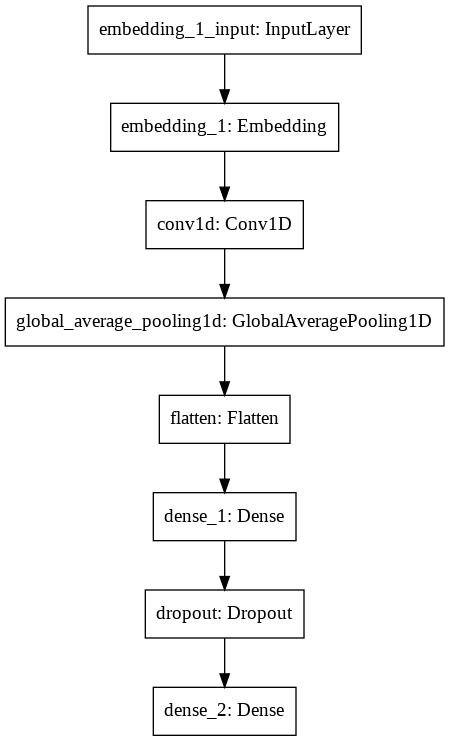

In [ ]:
#model diagram
tf.keras.utils.plot_model(model_cnn)

In [ ]:
#fit and evaluate on test data
history_cnn = model_cnn.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)
score_cnn = model_cnn.evaluate(X_test, y_test, verbose=1)

Epoch 1/10
924/924 [==============================] - 4s 5ms/step - loss: 0.9533 - acc: 0.5530 - val_loss: 0.8668 - val_acc: 0.6164
Epoch 2/10
924/924 [==============================] - 4s 4ms/step - loss: 0.8432 - acc: 0.6397 - val_loss: 0.8113 - val_acc: 0.6509
Epoch 3/10
924/924 [==============================] - 4s 4ms/step - loss: 0.7994 - acc: 0.6647 - val_loss: 0.7789 - val_acc: 0.6708
Epoch 4/10
924/924 [==============================] - 4s 4ms/step - loss: 0.7664 - acc: 0.6849 - val_loss: 0.7455 - val_acc: 0.6917
Epoch 5/10
924/924 [==============================] - 4s 4ms/step - loss: 0.7387 - acc: 0.7011 - val_loss: 0.7225 - val_acc: 0.7063
Epoch 6/10
924/924 [==============================] - 4s 4ms/step - loss: 0.7150 - acc: 0.7141 - val_loss: 0.7023 - val_acc: 0.7188
Epoch 7/10
924/924 [==============================] - 4s 4ms/step - loss: 0.6938 - acc: 0.7262 - val_loss: 0.6857 - val_acc: 0.7267
Epoch 8/10
924/924 [==============================] - 4s 4ms/step - loss: 0.

In [ ]:
#Visualize results
#Visualize results
print("Test Score of CNN model:", score_cnn[0])
print("Test Accuracy of CNN model:", score_cnn[1])

Test Score of CNN model: 0.6555012464523315
Test Accuracy of CNN model: 0.741287887096405


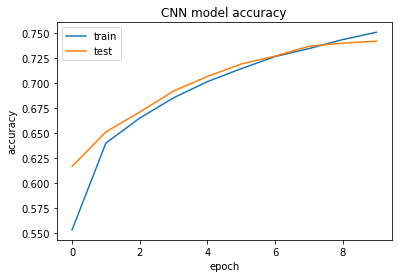

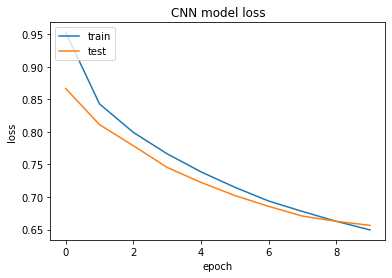

In [ ]:
plt.plot(history_cnn.history['acc'])
plt.plot(history_cnn.history['val_acc'])

plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])

plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
#get classification report and confusion matrix
cnn_sentiment,cnn_classification_report, cnn_confusionmatrix, cnn_confusionmatrix_df= predict_test(model_cnn,X_test, y_test, fit)

[2 0 1 ... 0 1 2]


In [ ]:
print(cnn_sentiment)
print(cnn_classification_report)
print(cnn_confusionmatrix)
print(cnn_confusionmatrix_df)

['positive' 'negative' 'neutral' ... 'negative' 'neutral' 'positive']
              precision    recall  f1-score   support

           0       0.72      0.79      0.75     12317
           1       0.79      0.64      0.71     12393
           2       0.73      0.80      0.76     12250

    accuracy                           0.74     36960
   macro avg       0.75      0.74      0.74     36960
weighted avg       0.75      0.74      0.74     36960

[[9729 1103 1485]
 [2420 7923 2050]
 [1455 1049 9746]]
               pred:negative  pred:neutral  pred:positive
true:negative           9729          1103           1485
true:neutral            2420          7923           2050
true:positive           1455          1049           9746


#Predicting on the COVID Tweets (No parameter tuning for CNN or RNN)

## RNN model

In [ ]:
#RNN model
tweets_data=tokenizer.texts_to_sequences(tweet_data_balanced['tweet_cleaned'].values)
tweets_data=pad_sequences(tweets_data, padding='post', maxlen=maxlen)


In [ ]:
X_rnn1 = model_rnn.predict(tweets_data)
X_rnn2=np.argmax(X_rnn1, axis=1)
tweet_data_balanced['sentiment_rnn']=X_rnn2

In [ ]:
tweet_data_balanced['sentiment_rnn']=tweet_data_balanced['sentiment_rnn'].replace([0,1,2],['negative','neutral','positive'])
tweets_data_positive_rnn = tweet_data_balanced[tweet_data_balanced['sentiment_rnn'] == 'positive']
print("Number of Positive tweets from RNN Model: %s" % str(len(tweets_data_positive_rnn.index)))

tweets_data_negative_rnn = tweet_data_balanced[tweet_data_balanced['sentiment_rnn'] == 'negative']
print("Number of Negative tweets from RNN Model: %s" % str(len(tweets_data_negative_rnn.index)))

tweets_data_neutral_rnn = tweet_data_balanced[tweet_data_balanced['sentiment_rnn'] == 'neutral']
print("Number of Neutral tweets from RNN Model: %s" % str(len(tweets_data_neutral_rnn.index)))

Number of Positive tweets from RNN Model: 50143
Number of Negative tweets from RNN Model: 29607
Number of Neutral tweets from RNN Model: 60663


(array([    0.,  2500.,  5000.,  7500., 10000., 12500., 15000., 17500.,
        20000., 22500.]), <a list of 10 Text major ticklabel objects>)

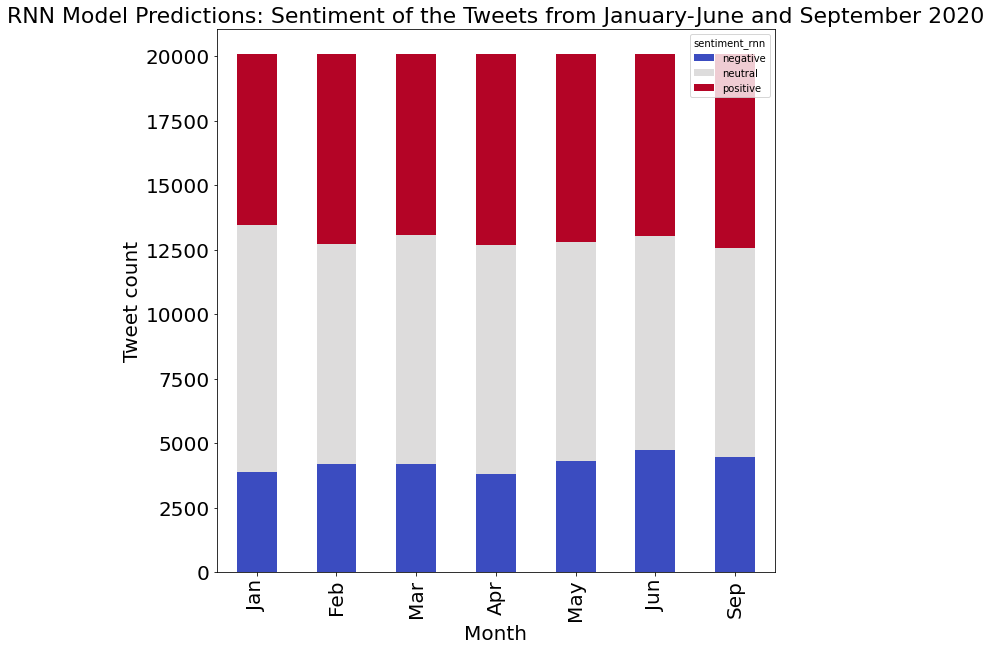

In [ ]:
order = ['Jan', 'Feb', 'Mar','Apr','May','Jun','Sep']
plot_tweet_date_rnn = tweet_data_balanced.groupby(['month', 'sentiment_rnn']).size().reset_index().pivot(columns='sentiment_rnn', index='month', values=0).loc[order].plot(kind='bar',colormap='coolwarm', stacked=True,figsize=(10,10))
#plot_tweet_date = tweets_post.groupby(['month', 'sentiment']).size().reset_index().pivot(columns='sentiment', index='month', values=0).plot(kind='bar',colormap='coolwarm', stacked=True,figsize=(10,10))
plot_tweet_date_rnn.set_xlabel("Month", fontsize= 20)
plot_tweet_date_rnn.set_ylabel("Tweet count", fontsize= 20)

plot_tweet_date_rnn.set_title("RNN Model Predictions: Sentiment of the Tweets from January-June and September 2020", fontname='Arial', fontsize=22)

# Set the font name for axis tick labels to be Comic Sans
for tick in plot_tweet_date_rnn.get_xticklabels():
    tick.set_fontname("Arial")
for tick in plot_tweet_date_rnn.get_yticklabels():
    tick.set_fontname("Arial")
    
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)  


## CNN model

In [ ]:
#CNN model
X_cnn1 = model_cnn.predict(tweets_data)
X_cnn2=np.argmax(X_cnn1, axis=1)
tweet_data_balanced['sentiment_cnn']=X_cnn2

In [ ]:
tweet_data_balanced['sentiment_cnn']=tweet_data_balanced['sentiment_cnn'].replace([0,1,2],['negative','neutral','positive'])

tweets_data_positive_cnn = tweet_data_balanced[tweet_data_balanced['sentiment_cnn'] == 'positive']
print("Number of Positive tweets from CNN Model: %s" % str(len(tweets_data_positive_cnn.index)))

tweets_data_negative_cnn = tweet_data_balanced[tweet_data_balanced['sentiment_cnn'] == 'negative']
print("Number of Negative tweets from CNN Model: %s" % str(len(tweets_data_negative_cnn.index)))

tweets_data_neutral_cnn = tweet_data_balanced[tweet_data_balanced['sentiment_cnn'] == 'neutral']
print("Number of Neutral tweets from CNN Model: %s" % str(len(tweets_data_neutral_cnn.index)))

Number of Positive tweets from CNN Model: 57825
Number of Negative tweets from CNN Model: 43423
Number of Neutral tweets from CNN Model: 39165


(array([    0.,  2500.,  5000.,  7500., 10000., 12500., 15000., 17500.,
        20000., 22500.]), <a list of 10 Text major ticklabel objects>)

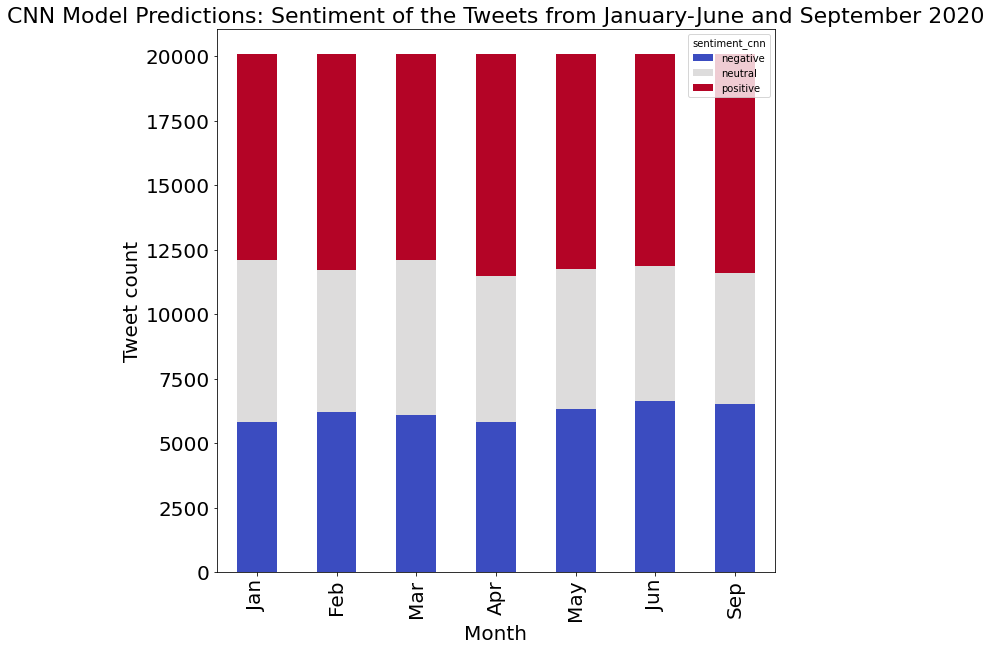

In [ ]:
order = ['Jan', 'Feb', 'Mar','Apr','May','Jun','Sep']
plot_tweet_date_cnn = tweet_data_balanced.groupby(['month', 'sentiment_cnn']).size().reset_index().pivot(columns='sentiment_cnn', index='month', values=0).loc[order].plot(kind='bar',colormap='coolwarm', stacked=True,figsize=(10,10))
#plot_tweet_date = tweets_post.groupby(['month', 'sentiment']).size().reset_index().pivot(columns='sentiment', index='month', values=0).plot(kind='bar',colormap='coolwarm', stacked=True,figsize=(10,10))
plot_tweet_date_cnn.set_xlabel("Month", fontsize= 20)
plot_tweet_date_cnn.set_ylabel("Tweet count", fontsize= 20)

plot_tweet_date_cnn.set_title("CNN Model Predictions: Sentiment of the Tweets from January-June and September 2020", fontname='Arial', fontsize=22)

# Set the font name for axis tick labels to be Comic Sans
for tick in plot_tweet_date_cnn.get_xticklabels():
    tick.set_fontname("Arial")
for tick in plot_tweet_date_cnn.get_yticklabels():
    tick.set_fontname("Arial")
    
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)  


#  Neural Network Model
## Hyperparameter Tuning

### CNN model

In [ ]:
#Define class of tuned model
from kerastuner import HyperModel
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Embedding, Conv1D, Dropout, GlobalAveragePooling1D, Flatten

#The trained model trials are located in folder TunedCNN
#****Instruction: copy the folder untitled_project within TunedCNN and paste it to the current directory. The model has not been saved to the directory.
class CNNHyperModel(HyperModel):
    def __init__(self, num_classes):
        #self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        global vocab_size
        model_cnn= Sequential(name= "CNN_MODEL")
        #model_cnn.add(InputLayer(input_shape=self.input_shape, name='input'))
        model_cnn.add(Embedding(vocab_size,100,weights=[embedding_matrix],input_length=maxlen))
        model_cnn.add(Conv1D
                      (filters=hp.Choice('num_filters',values=[32,64],default=32),
                       kernel_size=3, 
                       padding='same',
                       activation='relu'))
        model_cnn.add(GlobalAveragePooling1D())
        model_cnn.add(Flatten())
        model_cnn.add(Dense
                      (units=hp.Int('units',min_value=32, max_value=96, step=32, default=32),
                       activation=hp.Choice('dense_activation',values=['relu','sigmoid'],default='relu')))
        model_cnn.add(
            Dropout(rate=hp.Float(
                'dropout_1',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.005)))
            
        model_cnn.add(Dense(self.num_classes, activation='softmax'))

        model_cnn.compile(
            optimizer= Adam(
                hp.Float('learning_rate',
                         min_value=0.0001,
                         max_value=0.01,
                         sampling='LOG',
                         default=0.001)),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
        print(model_cnn.summary())
        return model_cnn

In [ ]:
hypermodel_cnn = CNNHyperModel(num_classes=3)

In [ ]:
#from kerastuner.tuners import Hyperband
from kerastuner.tuners import BayesianOptimization
es = EarlyStopping(monitor='val_loss', mode='min', patience=2)
tuner_cnn = BayesianOptimization(hypermodel_cnn,objective = 'val_accuracy', 
                      seed=1234, max_trials=10)
#Hyperband algorithm takes a lot longer to train, and the preliminary result appears to be around 87% accuracy which is not significantly different from using BayesianOptimization tuner
#tuner_cnn = Hyperband(hypermodel_cnn,objective = 'val_accuracy', 
#                      max_epochs = 10, seed=1234, executions_per_trial=2, 
#                      project_name='AIT726',
#                     directory='hyperband')
tuner_cnn.search_space_summary()

tuner_cnn.search(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2, callbacks=[es])
tuner_cnn.results_summary()

best_cnn = tuner_cnn.get_best_models(num_models=1)[0]

In [ ]:
score_tcnn = best_cnn.evaluate(X_test, y_test, verbose=1)
print("Test Score of CNN model:", score_tcnn[0])
print("Test Accuracy of CNN model:", score_tcnn[1])

#Predicting on the COVID Tweets (Parameter tuning for CNN)

Tuned CNN Model

In [ ]:
#CNN model
X_tuned_cnn1 = best_cnn.predict(tweets_data)
X_tuned_cnn2=np.argmax(X_tuned_cnn1, axis=1)
tweet_data_balanced['sentiment_tuned_cnn']=X_tuned_cnn2


tweet_data_balanced['sentiment_tuned_cnn']=tweet_data_balanced['sentiment_tuned_cnn'].replace([0,1,2],['negative','neutral','positive'])

tweets_data_positive_tuned_cnn = tweet_data_balanced[tweet_data_balanced['sentiment_tuned_cnn'] == 'positive']
print("Number of Positive tweets from Tuned CNN Model: %s" % str(len(tweets_data_positive_tuned_cnn.index)))

tweets_data_negative_tuned_cnn = tweet_data_balanced[tweet_data_balanced['sentiment_tuned_cnn'] == 'negative']
print("Number of Negative tweets from Tuned CNN Model: %s" % str(len(tweets_data_negative_tuned_cnn.index)))

tweets_data_neutral_tuned_cnn = tweet_data_balanced[tweet_data_balanced['sentiment_tuned_cnn'] == 'neutral']
print("Number of Neutral tweets from Tuned CNN Model: %s" % str(len(tweets_data_neutral_tuned_cnn.index)))

Number of Positive tweets from Tuned CNN Model: 51375<br>
Number of Negative tweets from Tuned CNN Model: 28561<br>
Number of Neutral tweets from Tuned CNN Model: 60477

In [ ]:
order = ['Jan', 'Feb', 'Mar','Apr','May','Jun','Sep']
plot_tweet_date_tuned_cnn = tweet_data_balanced.groupby(['month', 'sentiment_tuned_cnn']).size().reset_index().pivot(columns='sentiment_tuned_cnn', index='month', values=0).loc[order].plot(kind='bar',colormap='coolwarm', stacked=True,figsize=(10,10))
#plot_tweet_date = tweets_post.groupby(['month', 'sentiment']).size().reset_index().pivot(columns='sentiment', index='month', values=0).plot(kind='bar',colormap='coolwarm', stacked=True,figsize=(10,10))
plot_tweet_date_tuned_cnn.set_xlabel("Month", fontsize= 20)
plot_tweet_date_tuned_cnn.set_ylabel("Tweet count", fontsize= 20)

plot_tweet_date_tuned_cnn.set_title("Tuned CNN Model Predictions: Sentiment of the Tweets from January-June and September 2020", fontname='Arial', fontsize=22)

# Set the font name for axis tick labels to be Comic Sans
for tick in plot_tweet_date_tuned_cnn.get_xticklabels():
    tick.set_fontname("Arial")
for tick in plot_tweet_date_tuned_cnn.get_yticklabels():
    tick.set_fontname("Arial")
    
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)  

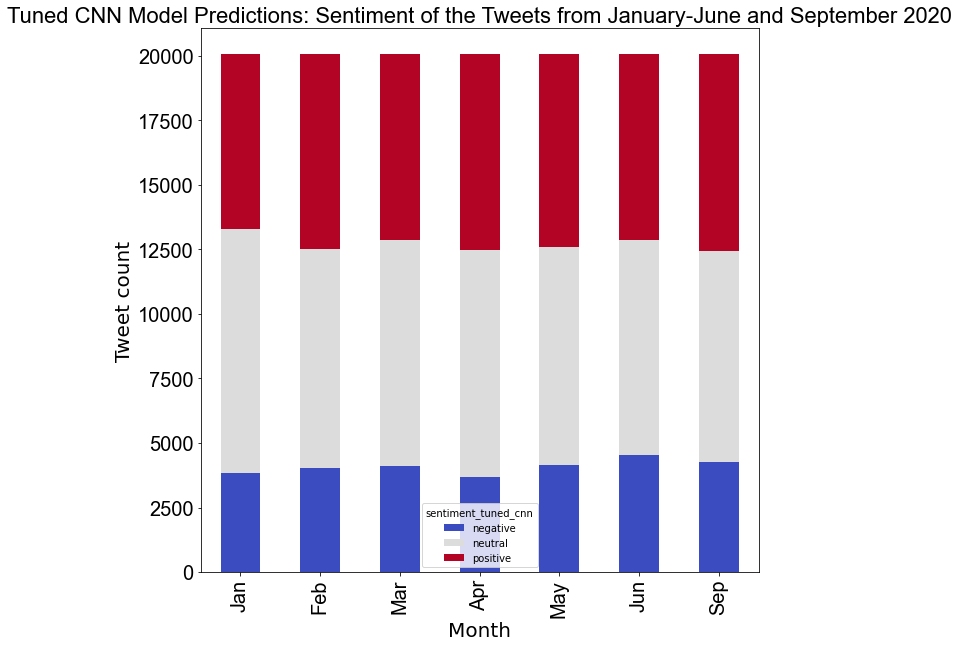

In [ ]:
cnn_sentiment,cnn_classification_report, cnn_confusionmatrix, cnn_confusionmatrix_df= predict_test(best_cnn,X_test, y_test, fit)
print(cnn_sentiment)
print(cnn_classification_report)
print(cnn_confusionmatrix)
print(cnn_confusionmatrix_df)
#screenshot because could not compile the model on google colab

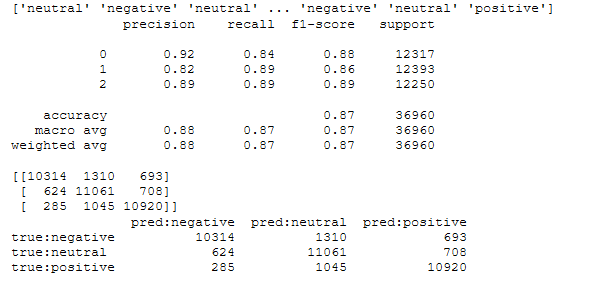
